# Exploring the UTx000 Extension Beiwe Data
(Known as BPEACE2 in the [GH repo](https://github.com/intelligent-environments-lab/utx000))

# GPS Inspection
The GPS data are a little wonky, so I want to take a closer look.

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Package Import

In [3]:
import sys
sys.path.append('../')

from src.features import build_features
from src.visualization import visualize

import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np

from datetime import datetime, timedelta
import math

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import geopy.distance

# Data Import

## GPS Data
The GPS data are available in the ```processed``` directory

In [4]:
gps = pd.read_csv('../data/processed/beiwe-gps-ux_s20.csv', index_col="timestamp", parse_dates=True, infer_datetime_format=True)
gps.tail()

,utc,lat,long,altitude,accuracy,beiwe
timestamp,,,,,,
2020-09-02 04:16:00,2020-09-02T09:16:00.999,30.36721,-97.79321,247.08321,4.93697,zdpffrox
2020-09-02 04:26:00,2020-09-02T09:26:18.637,30.36725,-97.79324,248.14131,65.00000,zdpffrox
2020-09-02 04:27:00,2020-09-02T09:27:02.598,30.36728,-97.79331,248.80050,5.10805,zdpffrox
2020-09-02 04:29:00,2020-09-02T09:29:11.145,30.36718,-97.79324,245.49971,65.00000,zdpffrox
2020-09-02 04:37:00,2020-09-02T09:37:18.698,30.36718,-97.79324,245.49971,112.29229,zdpffrox


In [5]:
n = len(gps['beiwe'].unique())
print(f'Number of Beiwe participants: {n}')

Number of Beiwe participants: 52


## Address Information
We can also take a look at how well the GPS coordinates tend to match up with addresses

In [6]:
info = pd.read_excel('../data/raw/utx000/admin/id_crossover.xlsx',sheet_name='beacon')
info.head()

,redcap,beiwe,beacon,start_date,end_date,move_date,return_date,lat,long,original_address,volume,housemates,roommates,n_rooms,no2_sensor,original_start,original_end,original_move,lat2,long2,second address,lat3,long3,third address
0,0.0,zdpffrox,7.0,2020-06-01 00:00:00,2020-09-01,NaT,2020-09-01,30.326815,-97.744665,"2211 Lawnmont Avenue apt 314 Austin, TX 78756",1365.0,1.0,1.0,NaN,Yes,2020-06-06,2020-09-03,2020-07-31,30.367307,-97.793199,"6500 champion grandview way apt 26104 Austin, ...",NaN,NaN,NaN
1,4.0,idbkjh8u,30.0,2020-06-11 10:07:00,2020-09-18,2020-08-15,2020-09-25,30.240268,-97.709502,"1301 Crossing Pl apt 1513, Austin, TX 78741",1080.0,0.0,0.0,4.0,No,2020-06-08,2020-09-09,2020-08-15,30.284696,-97.747237,"911 W 21st St Apt 2507, Austin, TX 78705",NaN,NaN,NaN
2,10.0,kyj367pi,1.0,2020-06-08 13:00:00,2020-09-03,2020-07-31,2020-09-02,30.295025,-97.744222,"2822 Rio Grande St. Apt 202 Austin, TX, 78705",1080.0,0.0,0.0,1.0,Yes,2020-06-15,NaT,2020-07-31,30.312614,-97.732338,"4605 Avenue A APT 214, Austin, TX, 78751",NaN,NaN,NaN
3,12.0,lkkjddam,21.0,2020-06-10 11:21:00,2020-09-16,2020-08-02,2020-09-15,32.679567,-95.699683,806 East High St. Grand Saline TX 75140,1188.0,0.0,0.0,3.0,Yes,2020-06-02,2020-09-14,2020-08-09,30.588371,-97.425863,"1307 Mallard Lane Taylor Tx, 76574",NaN,NaN,NaN
4,15.0,rnse61g4,34.0,2020-06-11 12:01:00,2020-08-22,2020-08-08,2020-08-21,30.285700,-97.744100,600 W. 26th St APT 3106 Austin TX 78705,1080.0,2.0,0.0,4.0,No,2020-06-06,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN


## Beacon/IEQ
We don't need the actual values from the beacon, but we do need to know if they are operating to see the overlap with the GPS coordinates. 

In [7]:
beacon = pd.read_csv('../data/processed/beacon-ux_s20.csv',index_col="timestamp", parse_dates=True, infer_datetime_format=True)
beacon.head()

,tvoc,lux,no2,co,co2,pm1_number,pm2p5_number,pm10_number,pm1_mass,pm2p5_mass,pm10_mass,temperature_c,rh,beacon,beiwe,fitbit,redcap
timestamp,,,,,,,,,,,,,,,,,
2020-06-08 13:00:00,59.283485,3.614880,3.526111,11.627447,NaN,12.081799,11.458559,50.644869,0.744280,24.767709,1.935866,16.244700,46.586667,1,kyj367pi,24.0,10
2020-06-08 13:02:00,59.501238,3.643950,3.526111,11.612331,NaN,12.157965,11.542477,51.183263,0.750738,25.379307,1.940782,16.257887,46.581250,1,kyj367pi,24.0,10
2020-06-08 13:04:00,60.484807,3.635160,3.529306,11.598771,NaN,12.044653,11.436841,50.524264,0.742682,24.874103,1.937115,16.269523,46.597059,1,kyj367pi,24.0,10
2020-06-08 13:06:00,61.532057,3.587340,3.529677,11.579456,NaN,12.019940,11.401453,50.289271,0.739928,24.503767,1.933971,16.279865,46.619444,1,kyj367pi,24.0,10
2020-06-08 13:08:00,62.381287,3.582777,3.530139,11.567426,NaN,12.040436,11.431434,50.488835,0.742263,24.824221,1.936699,16.289119,46.639474,1,kyj367pi,24.0,10


## Fitbit Sleep
Again, we don't need the actual values from the Fitbit but just to see if the participant recorded any nights of sleep.

### Sleep Stages
Do we need this?

In [8]:
ss = pd.read_csv("../data/processed/fitbit-sleep_stages-ux_s20.csv",parse_dates=["start_date","end_date","time"],infer_datetime_format=True)
ss.head()

,start_date,end_date,time,stage,time_at_stage,beiwe,value
0,2020-05-14,2020-05-14,2020-05-14 00:27:00,wake,510,hfttkth7,0
1,2020-05-14,2020-05-14,2020-05-14 00:35:30,light,420,hfttkth7,1
2,2020-05-14,2020-05-14,2020-05-14 00:42:30,deep,1590,hfttkth7,2
3,2020-05-14,2020-05-14,2020-05-14 01:09:00,light,1290,hfttkth7,1
4,2020-05-14,2020-05-14,2020-05-14 01:30:30,rem,840,hfttkth7,3


### Daily Sleep
We can use the timestamps

In [9]:
fb = pd.read_csv("../data/processed/fitbit-sleep_daily-ux_s20.csv",parse_dates=["start_time","end_time"],infer_datetime_format=True)
fb.head()

,duration_ms,efficiency,end_time,main_sleep,minutes_after_wakeup,minutes_asleep,minutes_awake,minutes_to_sleep,start_time,time_in_bed,date,beiwe,redcap,beacon,sol,wol
0,24360000,93.349754,2020-05-14 07:13:00,True,0,379,27,0,2020-05-14 00:27:00,406,2020-05-14,hfttkth7,NaN,NaN,8.5,0.0
1,29580000,79.513185,2020-05-15 08:06:30,True,8,392,101,0,2020-05-14 23:53:30,493,2020-05-15,hfttkth7,NaN,NaN,0.0,32.5
2,19740000,87.234043,2020-05-16 04:57:00,True,7,287,42,0,2020-05-15 23:28:00,329,2020-05-16,hfttkth7,NaN,NaN,11.5,11.0
3,26820000,90.156600,2020-05-17 09:28:30,True,8,403,44,0,2020-05-17 02:01:30,447,2020-05-17,hfttkth7,NaN,NaN,12.5,8.5
4,24960000,84.375000,2020-05-18 07:20:00,True,0,351,65,0,2020-05-18 00:24:00,416,2020-05-18,hfttkth7,NaN,NaN,11.5,0.0


# Distance Between Measurements
There is interest to know when the gps logs a data point and it might be due to the distance between subsequent points i.e. if the distance is greater than 50 meters, Biewe logs the point. 

In [10]:
def calculate_distance_between_measurements(gps_df, plot=False):
    """Calculates the distance between subsequent GPS measurements"""
    distances = []
    Lat = gps_df['lat'].values
    Long = gps_df['long'].values
    for i in range(len(gps_df)-1):

        coords_1 = (Lat[i], Long[i])
        coords_2 = (Lat[i+1], Long[i+1])

        distances.append(geopy.distance.distance(coords_1, coords_2).m)

    distances.append(0)
    print(f'The minimum distance: {np.nanmin(distances)}')
    # Plotting
    if plot:
        fig, ax = plt.subplots(figsize=(12,8))
        ax.hist(distances,bins=np.arange(0,205,5),rwidth=0.9,color='black')

        plt.show()
        plt.close()
        
    return distances

In [11]:
#distances = calculate_distance_between_measurements(gps)

<div class="alert alert-block alert-danger">

Doesn't seem to be any sort of cut-off value for the distances like I was told.

        
</div>

So seems like there might be a combination of distance and timestamp. The next step would be to see what the timesteps between distances would be.

In [12]:
def compare_distance_and_time_between_measurements(gps_df, distances, plot=False):
    """Calculates the distances between subsequent measurements and includes consideration for their timestamps"""
    gps = gps_df.copy()
    gps['distance'] = distances
    # looking at time between measurements
    # short distances
    gps_short_distance = gps[gps['distance'] < 50]
    dt = []
    for i in range(len(gps_short_distance)-1):
        t = (gps_short_distance.index[i+1] - gps_short_distance.index[i]).total_seconds()
        dt.append(t)

    # long distances
    gps_long_distance = gps[gps['distance'] > 50]
    dt_long = []
    for i in range(len(gps_long_distance)-1):
        t = (gps_long_distance.index[i+1] - gps_long_distance.index[i]).total_seconds()
        dt_long.append(t)
    
    if plot:
        fig, axes = plt.subplots(1,2,figsize=(12,8))
        ax = axes[0]
        ax.hist(dt,bins=np.arange(0,26,1),rwidth=0.9,color='black')

        ax = axes[1]
        ax.hist(dt_long,bins=np.arange(0,205,5),rwidth=0.9,color='black')

        plt.show()
        plt.close()
    
    return dt, gps_short_distance, dt_long, gps_long_distance

In [13]:
#compare_distance_and_time_between_measurements(gps, distances)

# Individual-Level Inspection
We want to look at a few individuals to get a sense of the data and what gaps are present. The entire study period is quite long so we can restrict the time frame if need be to get a better look.

In [14]:
gps['beiwe'].unique()

array(['15tejjtw', '1a9udoc5', '2xtqkfz1', '43b1cd5m', '4i7679py',
       '5fvmg226', '745vq78e', '789gcb6u', '7dhu3pn7', '8vpj3b9v',
       '9jtzsuu8', '9xmhtq74', 'awa8uces', 'axk49ssu', 'cnpj2xu4',
       'e73a1pd5', 'e8js2jdf', 'ewvz3zm1', 'eyf8oqwl', 'h8aoiyhv',
       'hcpu5myv', 'hfttkth7', 'hrqrneay', 'hxj6brwj', 'i31pt4b4',
       'i4w8dx6l', 'idbkjh8u', 'itmylz3g', 'kyj367pi', 'lkkjddam',
       'mm69prai', 'mv14b8aj', 'o6xwrota', 'olaxadz5', 'oxcpr7e3',
       'pgvvwyvh', 'q5y11ytm', 'qh34m4r9', 'r11k6uxz', 'rnse61g4',
       'rvhdl2la', 'shi1ykro', 't4jphih6', 'tlmlq19s', 'tmexej5v',
       'vpy1a985', 'vr9j5rry', 'xdbdrk6e', 'xlw5ntd5', 'xxvnhauv',
       'y1tvkx14', 'zdpffrox'], dtype=object)

Choosing randomly from the list above (first, last, and somewhere in the middle), we can inspect the GPS data. We look at the Lat and Long values for each participant of interest to make sure they match up. 

## Visual GPS Coordinate Inspection

In [15]:
def inspect_individual_gps(gps_df, pt, start_time=datetime(2020,6,7), end_time=datetime(2020,6,9)):
    """Plots lat and long values to see they have overlapping times"""
    fig, ax_lat = plt.subplots(figsize=(16,4))
    # gps data per individual
    gps_pt = gps_df[gps_df['beiwe'] == pt]
    # restricting again for the date
    gps_pt = gps_pt[start_time:end_time]
    # info per individual
    info_pt = info[info['beiwe'] == pt]
    # Plotting Lat
    ax_lat.scatter(gps_pt.index,gps_pt['lat'], color='cornflowerblue', s=5,label='Latitude')
    # Plotting Long on same axis
    ax_long = ax_lat.twinx()
    ax_long.scatter(gps_pt.index,gps_pt['long'], color='firebrick', s=5, label='Longitude')
    
    plt.show()
    plt.close()

In [ ]:
for pt in ['2xtqkfz1','xxvnhauv','itmylz3g']:
    inspect_individual_gps(gps,pt)

## Coordinate Inspection
We have a lot of data to check. We want to see:
1. if GPS coordinates match with address coordinates
2. beacon operation in relation to GPS logging
3. move-out dates correspond to _noticeable_ changes in GPS coordinates

In [16]:
def check_for_null(row,subset=None):
    """Checks to see if value is null in subset of columns within a row"""
    if row.count() > 0:
        return 1
    else:
        return 0

Participant 15tejjtw not given Beacon
Participant 1a9udoc5 not given Beacon


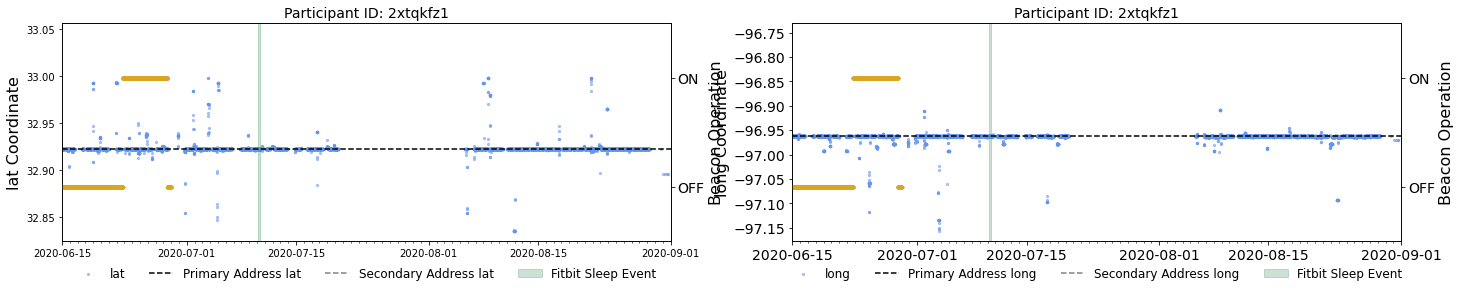

Participant 43b1cd5m not given Beacon


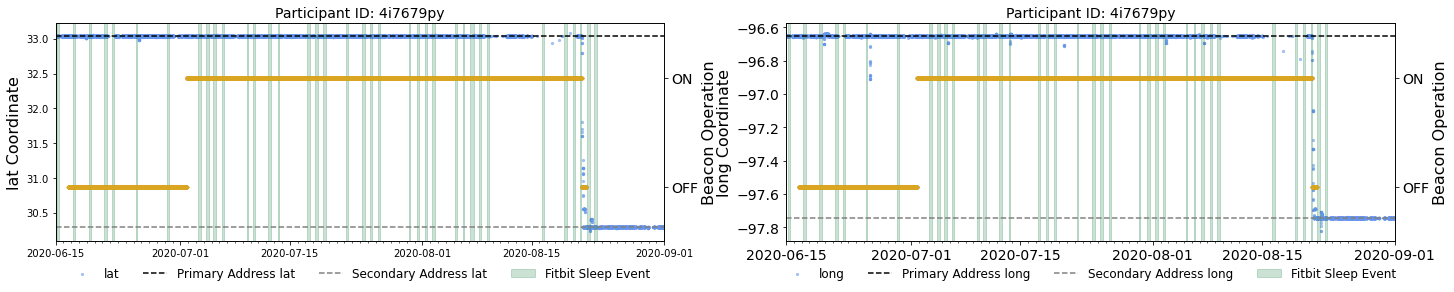

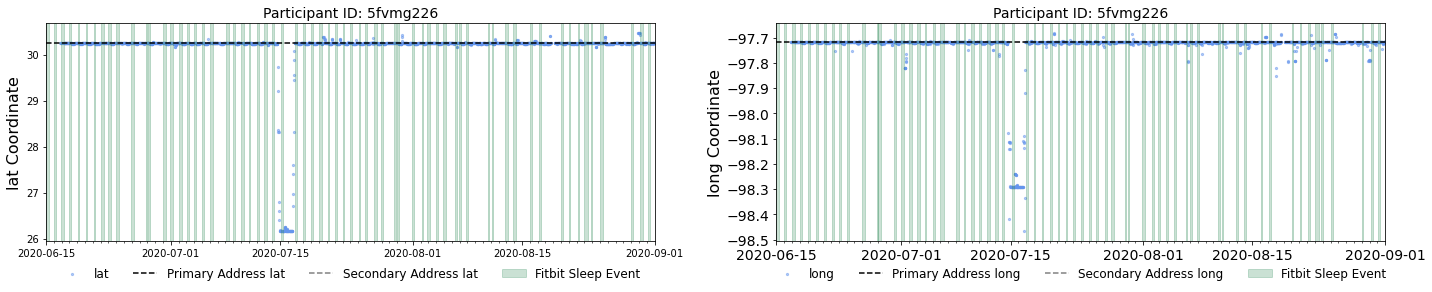

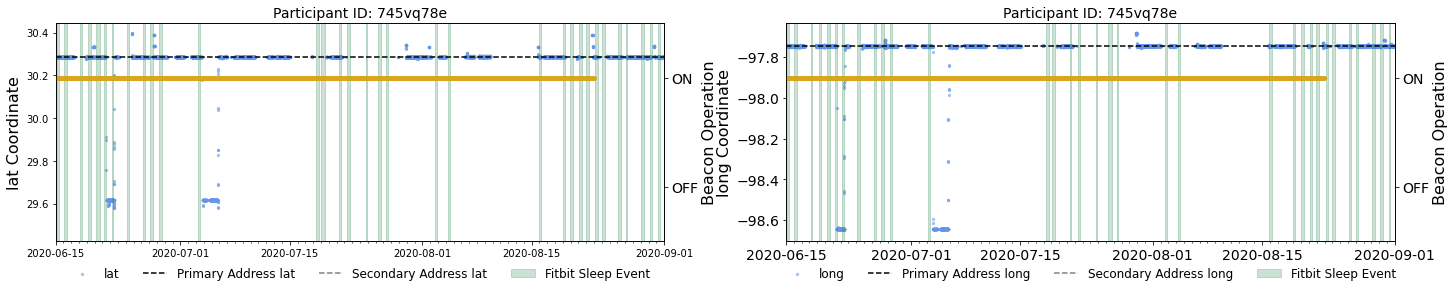

Participant 789gcb6u not given Beacon
Participant 7dhu3pn7 not given Beacon
Participant 8vpj3b9v not given Beacon


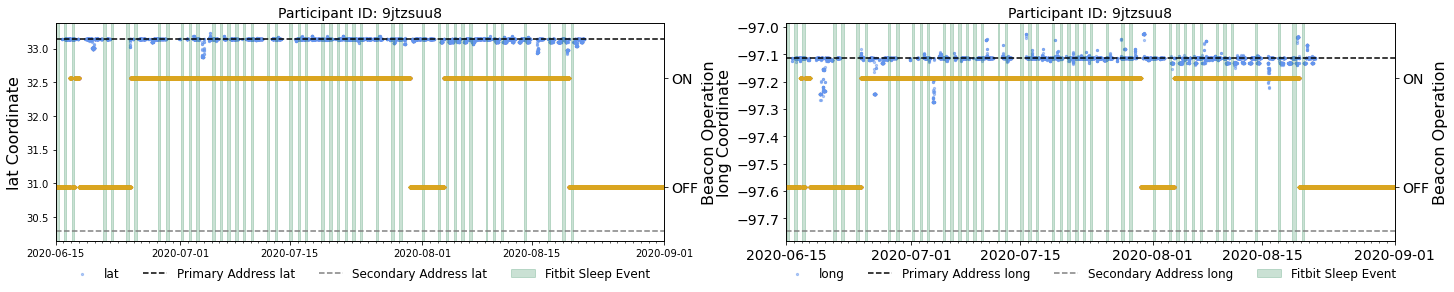

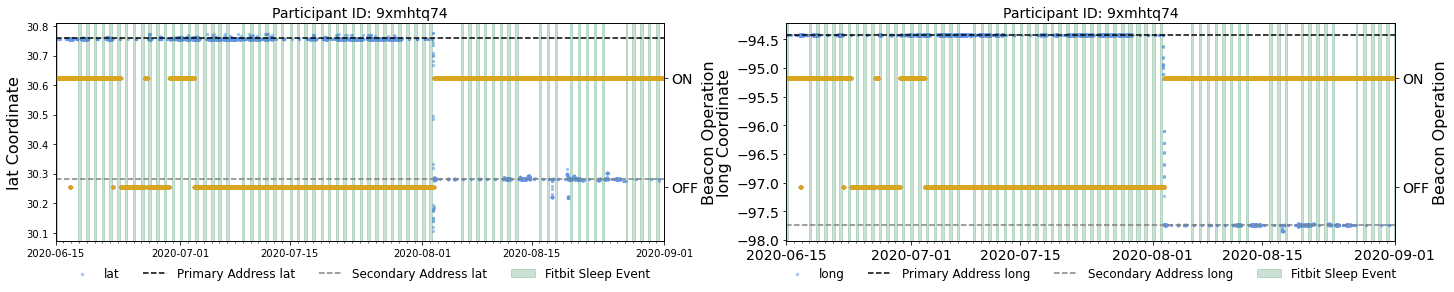

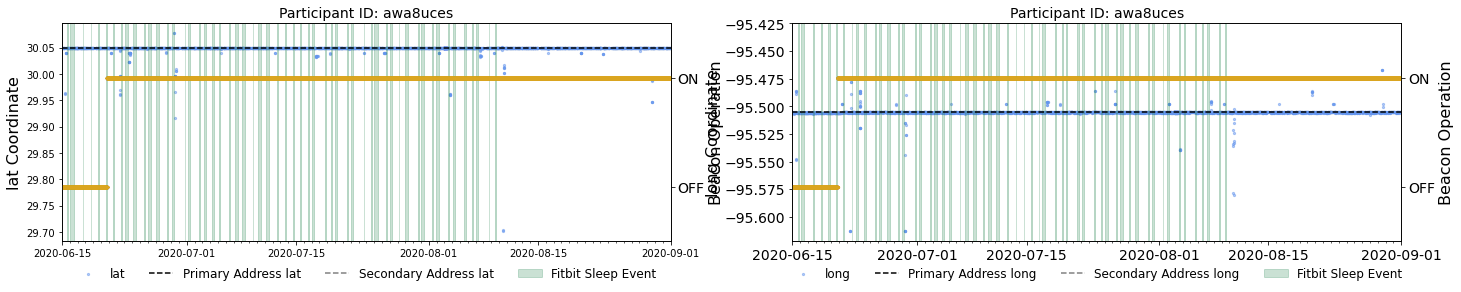

Participant axk49ssu not given Beacon
Participant cnpj2xu4 not given Beacon


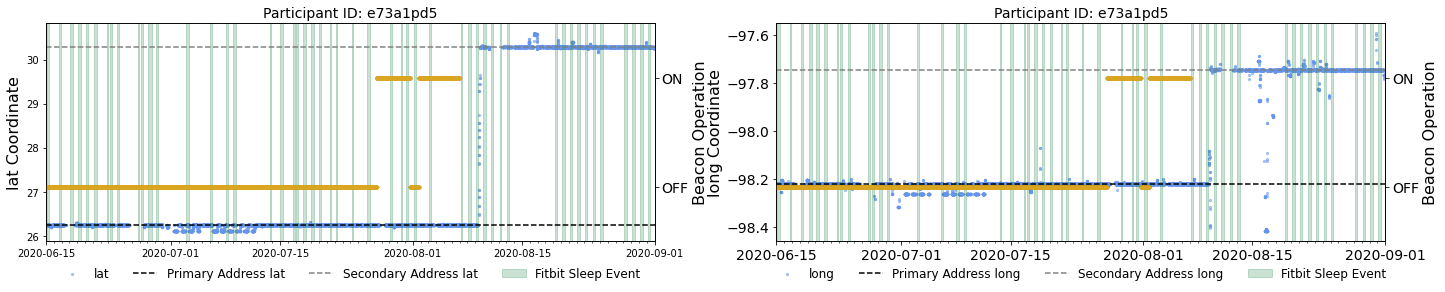

Participant e8js2jdf not given Beacon
Participant ewvz3zm1 not given Beacon
Participant eyf8oqwl not given Beacon
Participant h8aoiyhv not given Beacon


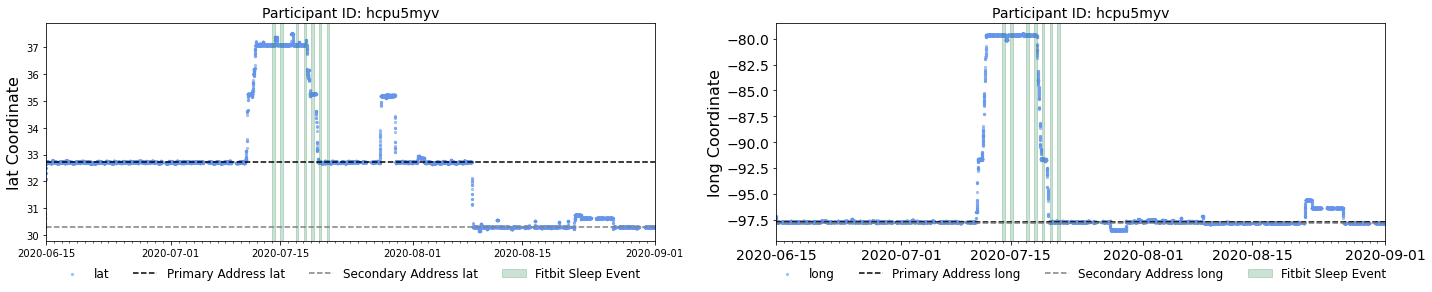

Participant hfttkth7 not given Beacon
Participant hrqrneay not given Beacon


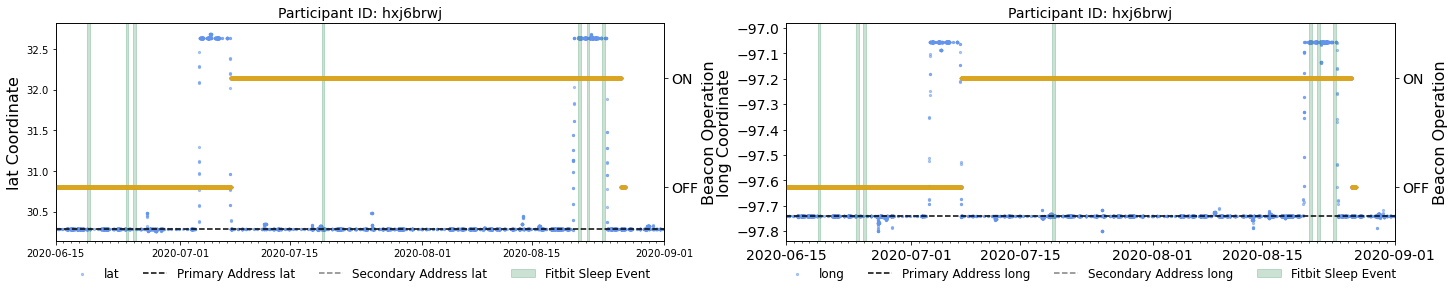

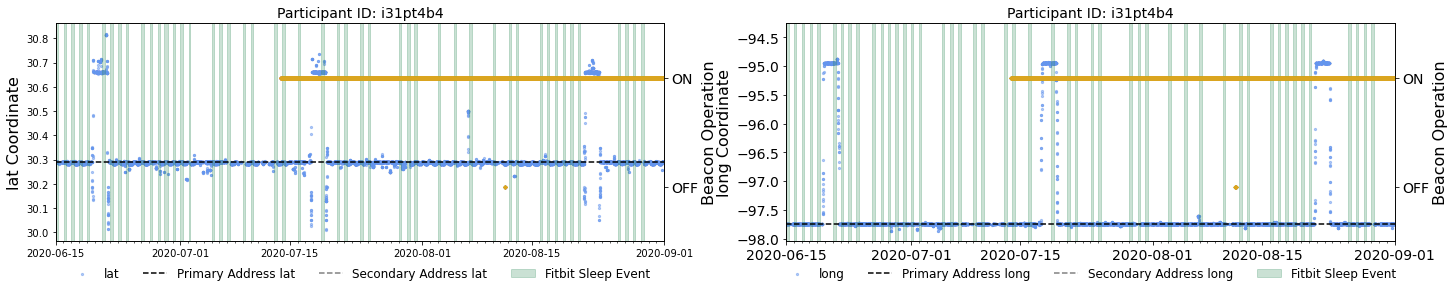

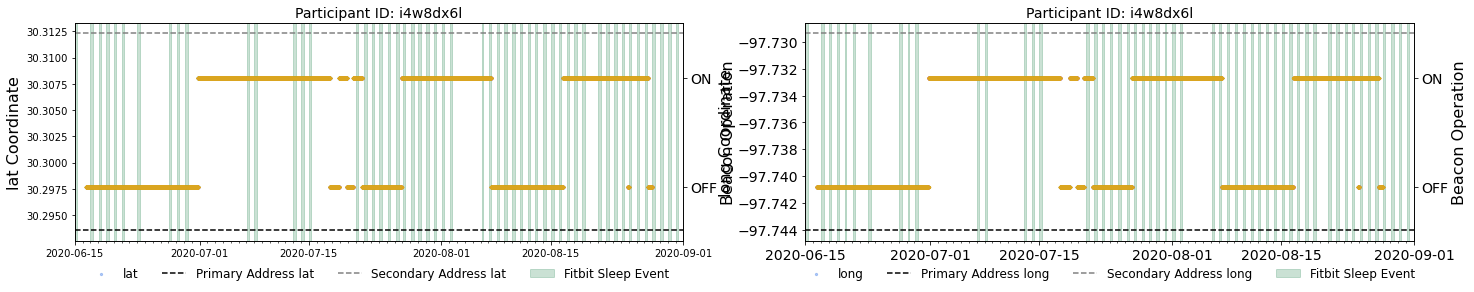

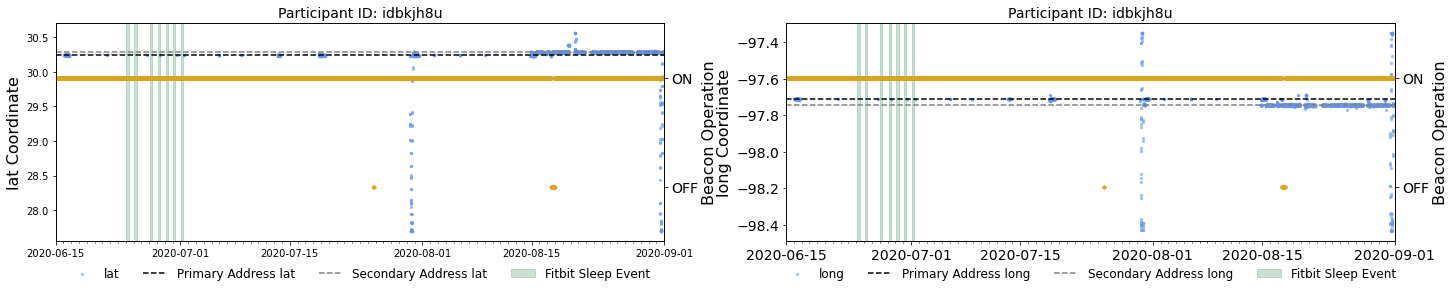

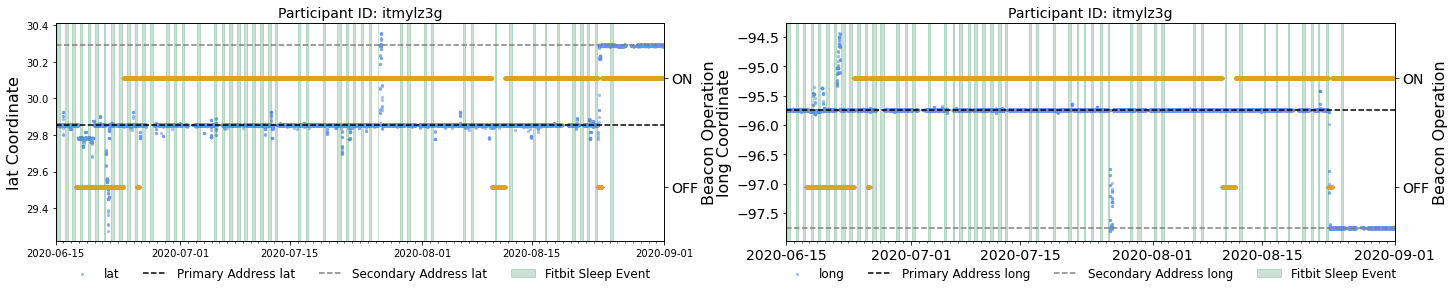

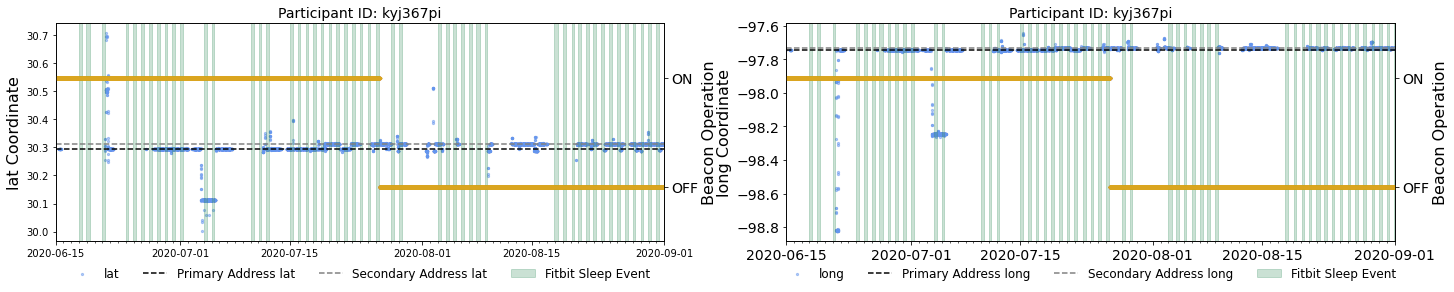

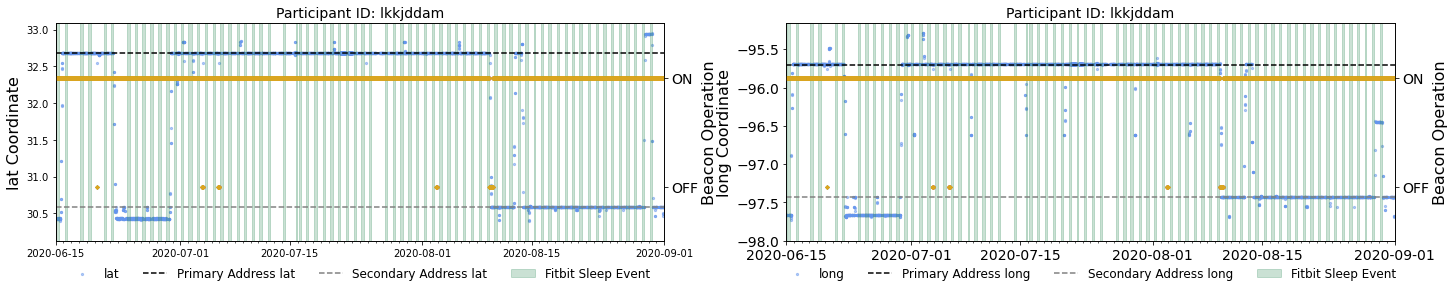

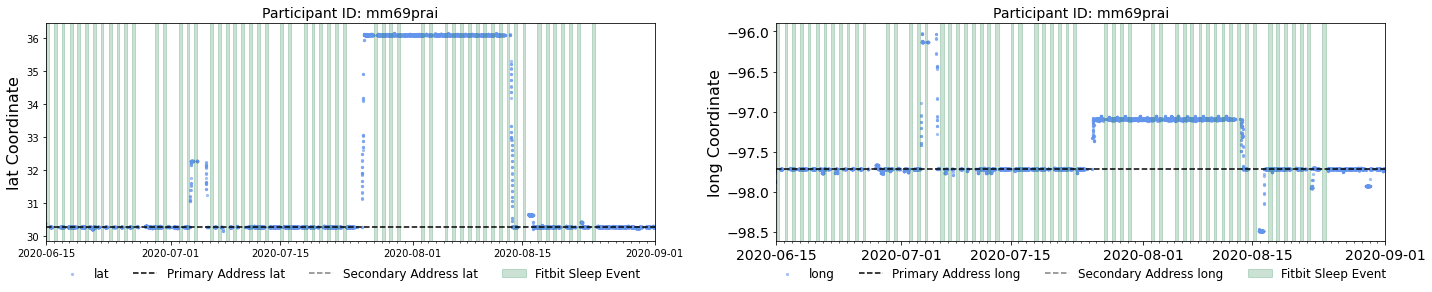

Participant mv14b8aj not given Beacon
Participant o6xwrota not given Beacon


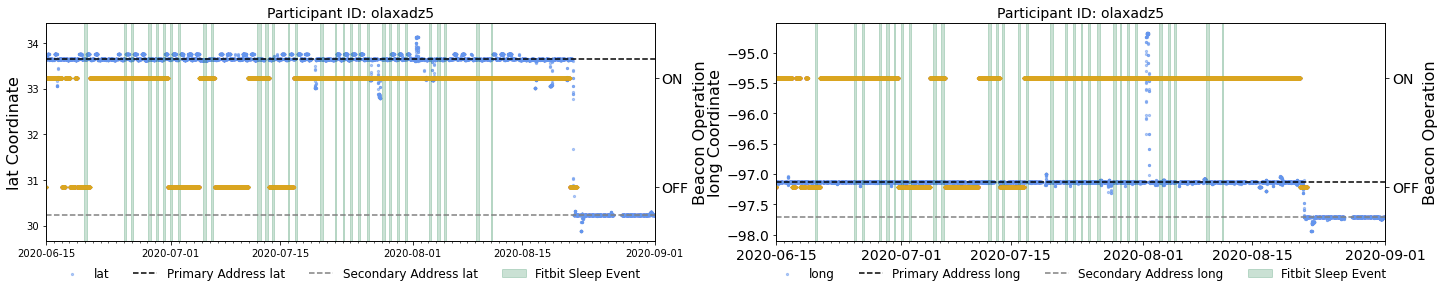

Participant oxcpr7e3 not given Beacon
Participant pgvvwyvh not given Beacon
Participant q5y11ytm not given Beacon


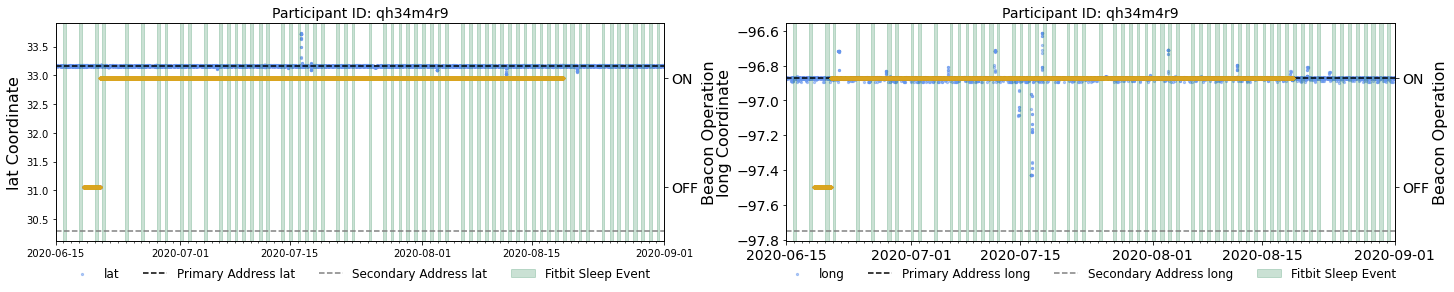

Participant r11k6uxz not given Beacon


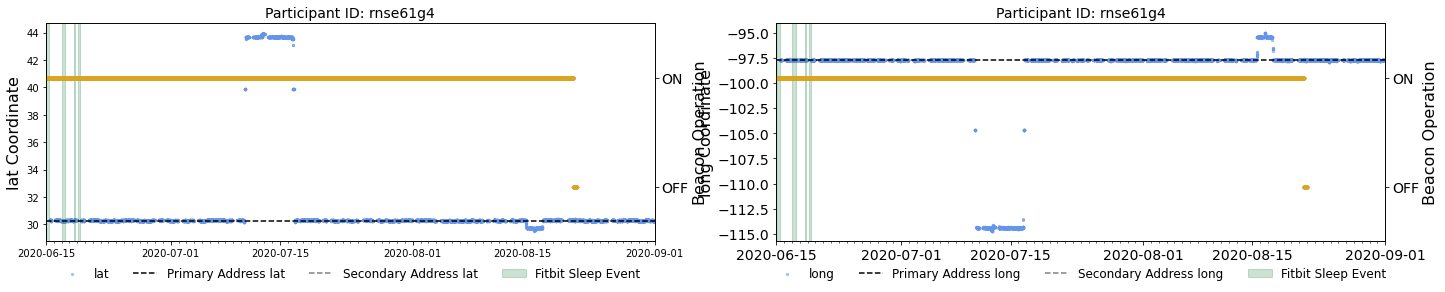

Participant rvhdl2la not given Beacon
Participant shi1ykro not given Beacon
Participant t4jphih6 not given Beacon


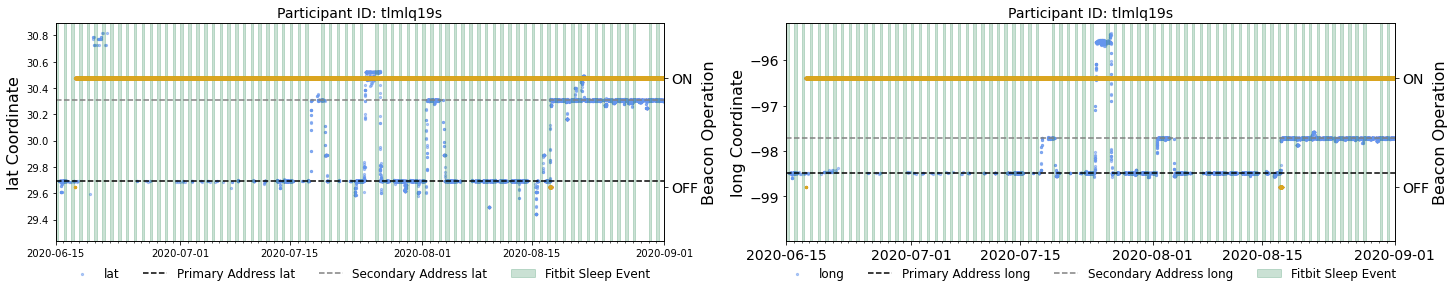

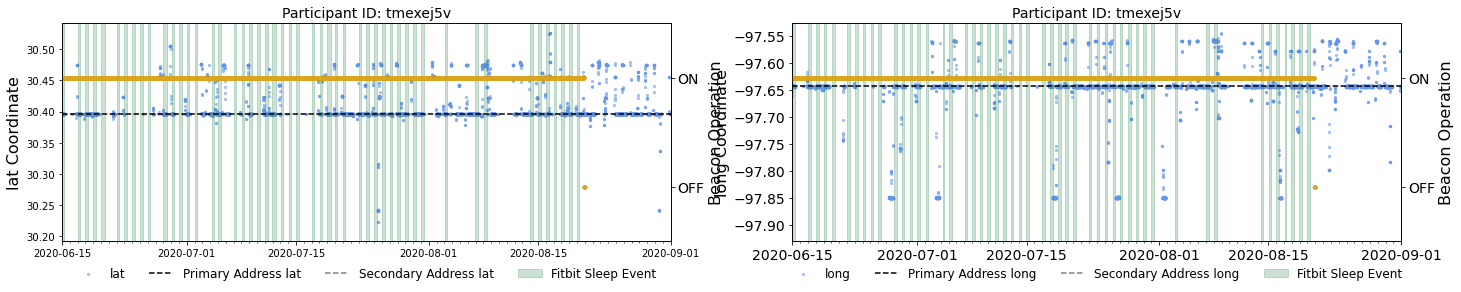

Participant vpy1a985 not given Beacon


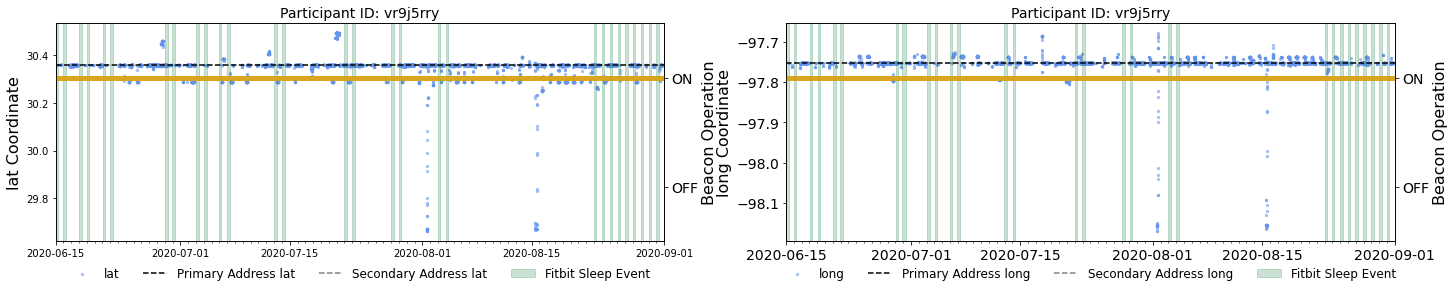

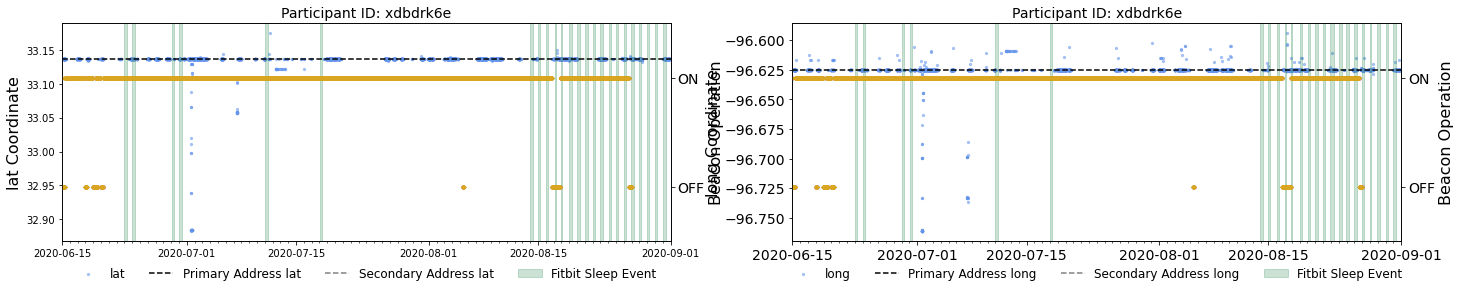

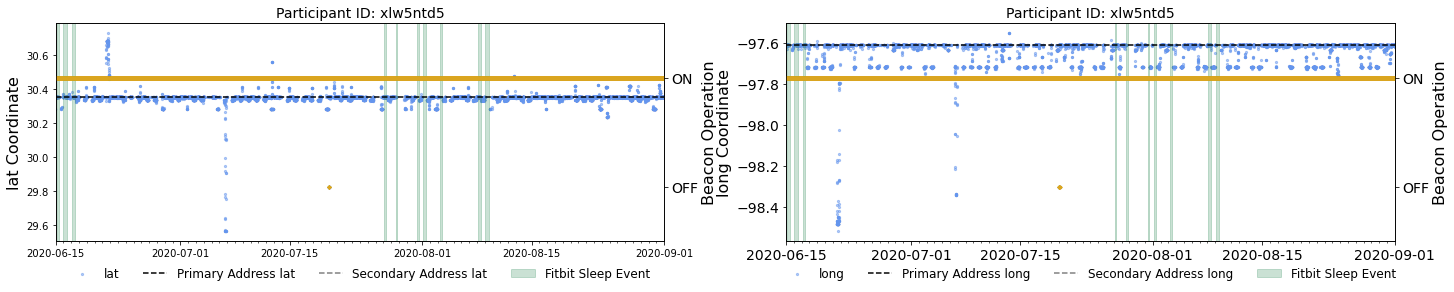

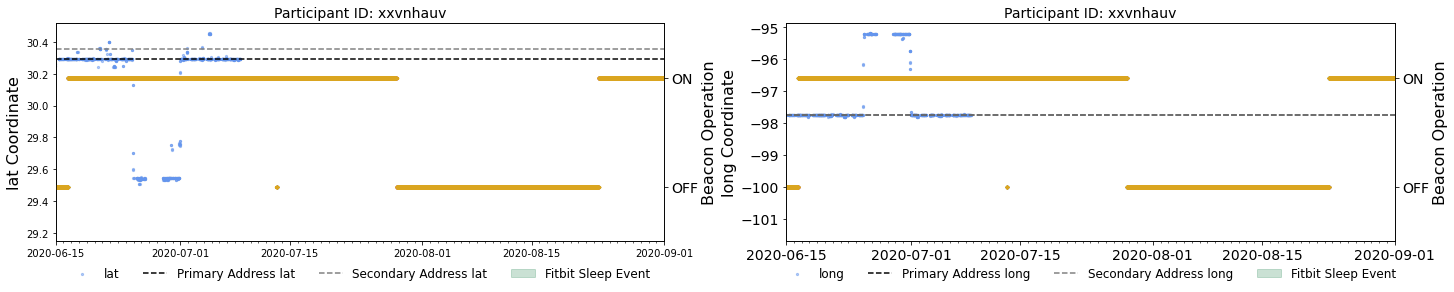

Participant y1tvkx14 not given Beacon


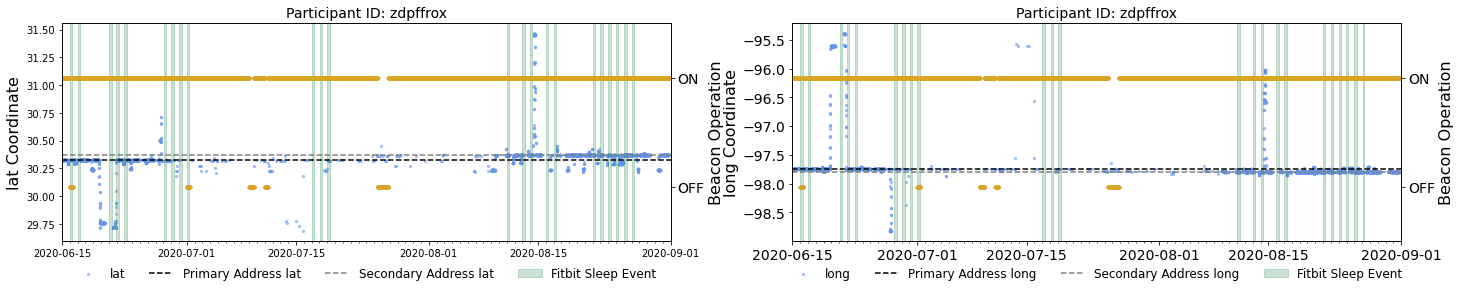

In [21]:
coord = "lat"
color = "cornflowerblue"
save = False
for pt in gps['beiwe'].unique():
    if pt in info['beiwe'].values:
        # gps data per individual
        gps_pt = gps[gps['beiwe'] == pt]
        # info per individual
        info_pt = info[info['beiwe'] == pt]
        # ieq per individual
        beacon_pt = beacon[beacon["beiwe"] == pt]
        # sleep per individual
        fb_pt = fb[fb["beiwe"] == pt]
        
        fig, axes = plt.subplots(1,2,figsize=(24,4))#,gridspec_kw={"w_space":0.2})
        for coord, ax in zip(["lat","long"], axes.flat):
            # gps
            lat_scat = ax.scatter(gps_pt.index,gps_pt[coord], color=color, s=5,alpha=0.5)
            # address(es)
            p_add = ax.axhline(info_pt[coord].values[0],color='black',linestyle='dashed',)
            s_add = ax.axhline(info_pt[f"{coord}2"].values,color="grey",linestyle="dashed")
            # move out
            #ax.axvline(info_pt['move_date'].values[0],color='black',linestyle='dashed')
            # sleep
            if len(fb_pt) > 0:
                for s, e in zip(pd.to_datetime(fb_pt["start_time"]),pd.to_datetime(fb_pt["end_time"])):
                    sleep_span = ax.axvspan(s,e,color="seagreen",alpha=0.25,zorder=1)

            ax.set_title(f'Participant ID: {pt}',fontsize=14)
            ax.xaxis.set_minor_locator(mdates.DayLocator())
            ax.set_xlim([datetime(2020,6,15),datetime(2020,9,1)])
            plt.xticks(fontsize=14)
            plt.yticks(fontsize=14)
            ax.set_ylabel(f"{coord} Coordinate",fontsize=16)

            # ieq measurements
            if len(beacon_pt) > 0:
                bb_scat = beacon_pt["operation"] = beacon_pt.apply(lambda row: check_for_null(row[["tvoc","co2","co","no2","pm2p5_mass"]]),axis="columns")
                ax_op = ax.twinx()
                ax_op.scatter(beacon_pt.index,beacon_pt["operation"],color="goldenrod",s=5)
                ax_op.set_ylim([-0.5,1.5])
                ax_op.set_yticks([0,1])
                ax_op.set_yticklabels(["OFF","ON"],fontsize=14)
                ax_op.set_ylabel("Beacon Operation",fontsize=16)

            ax.legend([lat_scat,bb_scat,p_add,s_add,sleep_span],[coord,"Beacon Operation",f"Primary Address {coord}",f"Secondary Address {coord}","Fitbit Sleep Event"],
                     loc="center",bbox_to_anchor=[0.5,-0.15],ncol=4,fontsize=12,frameon=False)
        
        if save:
            plt.savefig(f"../reports/figures/beacon_fitbit/ieq_sleep_gps_overlap-{pt}-ux_s20.png")
        plt.show()
        plt.close()

    else:
        print(f'Participant {pt} not given Beacon')

In [22]:
beacon_filtered = pd.read_csv("../data/processed/beacon-fb_and_gps_filtered-ux_s20.csv",index_col=0,parse_dates=["timestamp","start_time","end_time"],infer_datetime_format=True)
beacon_filtered.head()

,lat,long,altitude,accuracy,tvoc,lux,no2,co,co2,pm1_number,pm2p5_number,pm10_number,pm1_mass,pm2p5_mass,pm10_mass,temperature_c,rh,beacon,beiwe,fitbit,redcap,start_time,end_time
timestamp,,,,,,,,,,,,,,,,,,,,,,,
2020-07-20 01:05:00,32.70647,-97.69214,302.12914,16.00242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hcpu5myv,NaN,NaN,2020-07-20 00:22:00,2020-07-20 06:19:30
2020-07-20 01:10:00,32.70649,-97.69214,297.88901,110.55695,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hcpu5myv,NaN,NaN,2020-07-20 00:22:00,2020-07-20 06:19:30
2020-07-20 01:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hcpu5myv,NaN,NaN,2020-07-20 00:22:00,2020-07-20 06:19:30
2020-07-20 01:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hcpu5myv,NaN,NaN,2020-07-20 00:22:00,2020-07-20 06:19:30
2020-07-20 01:25:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hcpu5myv,NaN,NaN,2020-07-20 00:22:00,2020-07-20 06:19:30


In [19]:
def plot_beacon_operation(beacon_data,pid,ieq_parameters=["tvoc","co2","co","pm2p5_mass"],save=False):
    """"""
    df_to_plot = beacon_data.copy()
    fig, ax = plt.subplots(figsize=(16,4))
    df_to_plot["operation"] = df_to_plot.apply(lambda row: check_for_null(row[ieq_parameters]),axis="columns")
    ax.scatter(df_to_plot.index,df_to_plot["operation"],color="goldenrod",s=5)
    ax.set_ylim([-0.5,1.5])
    ax.set_yticks([])
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    ax.set_xlim([datetime(2020,6,15),datetime(2020,9,1)])
    plt.xticks(fontsize=14)
    ax.set_title(f"Participant ID: {pid}",fontsize=14)
    if save:
        plt.savefig(f"../reports/figures/beacon_fitbit/filtered_beacon_operation-{pid}-ux_s20.png")

    plt.show()
    plt.close()

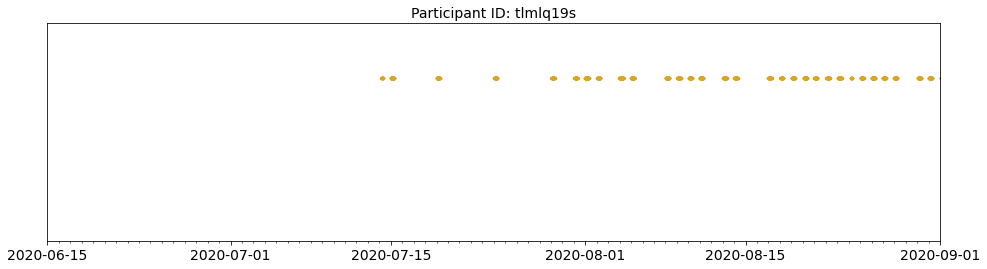

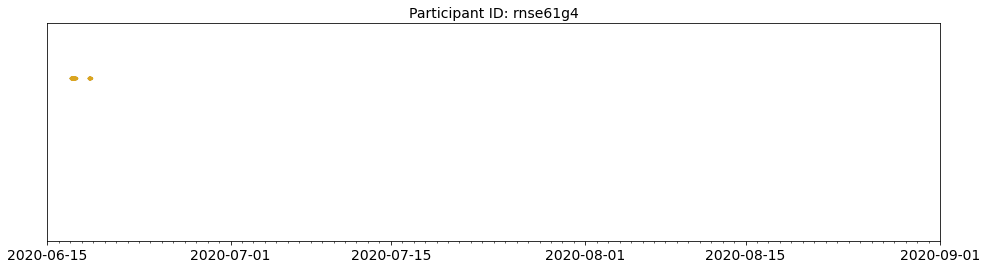

In [20]:
for pt in ["tlmlq19s","rnse61g4"]:
    beacon_filtered_by_pt = beacon_filtered[beacon_filtered['beiwe'] == pt]
    plot_beacon_operation(beacon_filtered_by_pt,pt,save=True)

Patient 15tejjtw not given Beacon
Patient 1a9udoc5 not given Beacon


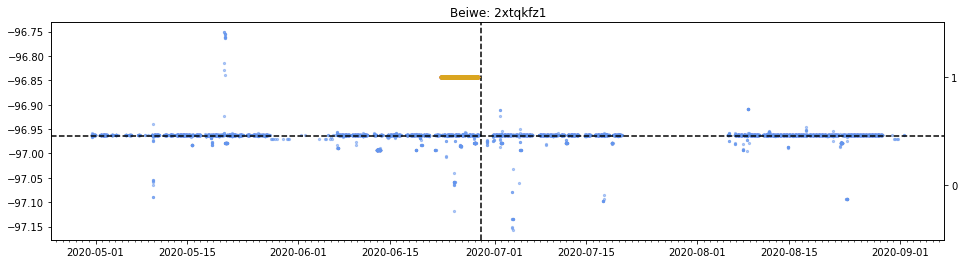

Patient 43b1cd5m not given Beacon


KeyboardInterrupt: 

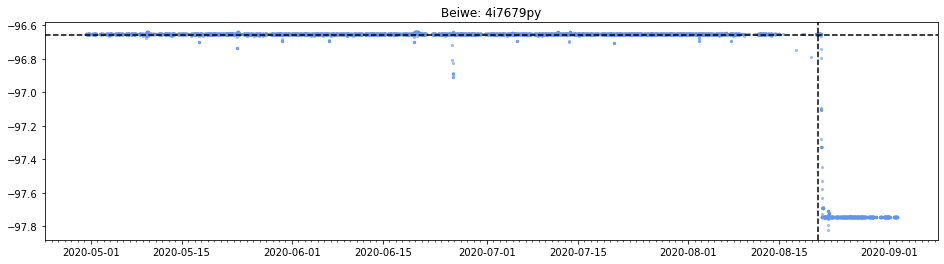

In [21]:
coord = "long"
for pt in gps['beiwe'].unique():
    if pt in info['beiwe'].values:
        fig, ax = plt.subplots(figsize=(16,4))
        # gps data per individual
        gps_pt = gps[gps['beiwe'] == pt]
        # info per individual
        info_pt = info[info['beiwe'] == pt]
        # ieq per individual
        beacon_pt = beacon[beacon["beiwe"] == pt]

        ax.scatter(gps_pt.index,gps_pt[coord], color=color, s=5,alpha=0.5)
        ax.axhline(info_pt[coord].values[0],color='black',linestyle='dashed')
        ax.axvline(info_pt['move_date'].values[0],color='black',linestyle='dashed')
        ax.set_title(f'Beiwe: {pt}')
        ax.xaxis.set_minor_locator(mdates.DayLocator())


        if len(beacon_pt) > 0:
            beacon_pt["operation"] = beacon_pt.apply(lambda row: check_for_null(row[["tvoc","co2","co","no2","pm2p5_mass"]]),axis="columns")
            ax_op = ax.twinx()
            ax_op.scatter(beacon_pt.index,beacon_pt["operation"],color="goldenrod",s=5)
            ax_op.set_ylim([-0.5,1.5])
            ax_op.set_yticks([0,1])

        plt.show()
        plt.close()

    else:
        print(f'Patient {pt} not given Beacon')

<div class="alert alert-block alert-danger">
Initial inspection shows that move-out dates do NOT correspond with the GPS data. 

## Beacon and GPS Overlap
Here we look to see if participants that logged Beacon data also logged GPS data.

In [ ]:
beacon_df = pd.read_csv('../data/processed/beacon-ux_s20.csv',index_col="timestamp")
# GPS
pt_list = []
bb_list = []
# info
info_pt_list = []
info_bb_list = []
for pt, bb in zip(beacon_df['beiwe'].unique(),beacon_df['beacon'].unique()):
    if pt in gps['beiwe'].unique():
        pt_list.append(pt)
        bb_list.append(bb)
    if pt in info['beiwe'].unique():
        info_pt_list.append(pt)
        info_bb_list.append(bb)

Comparing the beacons

In [ ]:
print('Number of Beacon users with GPS logged:',len(bb_list))
print('\tGPS Beacons:', bb_list)
print('\tAll Beacons:', beacon_df['beacon'].unique())
print('\tInfo Beacons:', info_bb_list)